# Numpyro and Hamiltonian Monte Carlo

In this tutorial we will see how we to integrate our ∂Lux optical models with a Probablistic Programming Language (PPL) Numpyro. This allows us to run a subset of MCMC algorithms known as HMC, that take advantage of autodiff in order to infer the relationship between a large number of parameters.

In this example we will simulate a binary star through a simple optical system, and simultanesouly infer the parameters of the stars and the state of the optical system at the same time.

---

In [1]:
# Core jax
import jax
import jax.numpy as np
import jax.random as jr

# PPL
import numpyro as npy
import numpyro.distributions as dist

# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl

# Plotting/visualisation
import matplotlib.pyplot as plt
import chainconsumer as cc

# Set global plotting parameters
%matplotlib inline
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


<Figure size 640x480 with 0 Axes>

First we want to create our spectral object for our binary star source, and then create the binary star object

In [2]:
# Create Combined Spectrum for Binary
wavels = np.linspace(400e-9, 500e-9, 3)

# Create Binary Source
true_position = np.zeros(2)
true_separation = dl.utils.arcseconds_to_radians(8e-2)
true_position_angle = np.pi/2
true_flux = 1e3
true_contrast = 2
source = dl.BinarySource(true_position, true_flux, true_separation, 
                         true_position_angle, true_contrast, 
                         wavelengths=wavels, name="Binary")

Next we define the optical system and detector, and combine then with the binary soure in order to create a telescope object that we will use to model all of these components simultaneously.

In [3]:
# Construct Optical system
wf_npix = 128
det_npix = 16

# Zernike aberrations
# zernike_basis = dl.utils.zernike_basis(10, npix=wf_npix)[3:] * 1e-9
zernike_basis = np.arange(3, 10)
true_coeffs = 1e-9 * jr.normal(jr.PRNGKey(0), (zernike_basis.shape[0],))

# Construct optical layers
true_pixel_scale = dl.utils.arcseconds_to_radians(30e-3)
layers = [dl.CreateWavefront(wf_npix, 1),
        #   dl.CompoundAperture([0.5]),
        #   dl.ApplyBasisOPD(basis, true_coeffs),
          dl.SimpleAperture(wf_npix, zernikes=zernike_basis, coefficients=true_coeffs),
          dl.NormaliseWavefront(),
          dl.AngularMFT(det_npix, true_pixel_scale)]

# Construct Detector
true_bg = 10.
true_pixel_response = 1 + 0.05*jr.normal(jr.PRNGKey(0), (det_npix, det_npix))
detector_layers = [dl.AddConstant(true_bg)]

# Construct Telescope
telescope = dl.Instrument(dl.Optics(layers), 
                          dl.Scene([source]),
                          detector=dl.Detector(detector_layers))

Now lets create the fake data and examine it. Note that for Numpyro we will flatten our data to make it easier to interact with

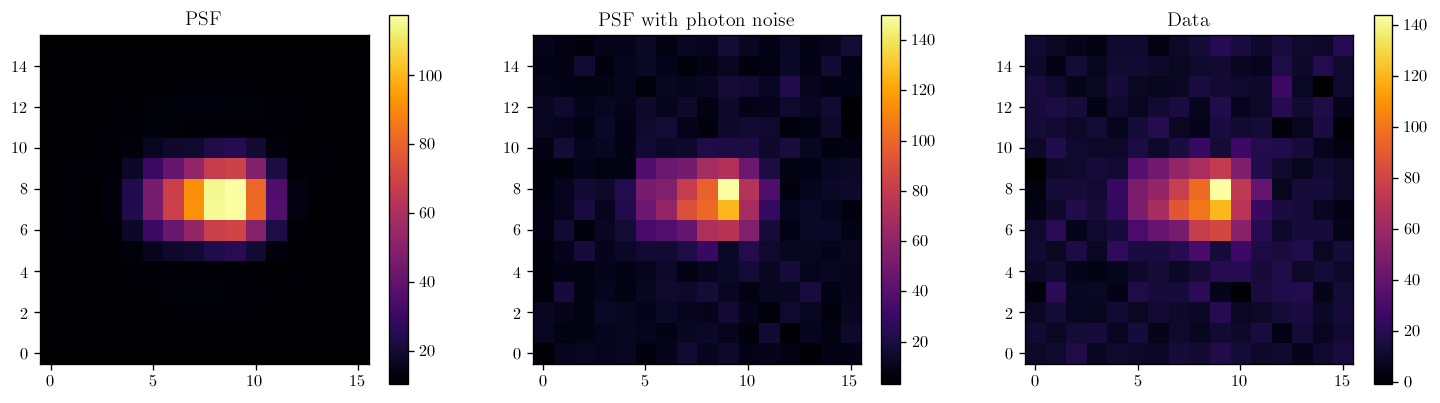

In [4]:
## Gerenate psf
psf = telescope.model()
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 3*jr.normal(jr.PRNGKey(0), psf_photon.shape)
image = psf_photon + bg_noise
data = image.flatten()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("PSF with photon noise")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(image)
plt.colorbar()
plt.show()

---

# Inference with Numpyro

Awesome, now we are going to try and infer these parameters using an MCMC algortihm. There a few different parameters we want to learn:

##  Binary parameters
 - The (x,y) mean position (2 parameters)
 - The separation (1 parameter)
 - The position angle (1 parameter)
 - The mean flux (1 parameter)
 - The contrast ratio (1 parameter)
 
## Optical parameters
 - The zernike aberration coefficients (7 parameters)
 
## Detector parameters
 - The mean detector noise (1 parameter)
 
This gives us a total of 14 parameters, which is quite high dimensional for regular MCMC algortihms.

Now we construct our Numpyro sampling function. In this function we need to define priors distribution variables for our parameters, and feed them (along with the corresponsing path to that parameter in the model) into the .update_and_model() function. This allows for Numpyro to simulatensly sample the posterior for all of the parameters by taking advantage of the differentiable nature of these models. 

With these parameters we define a 'plate' which defines our data, using a Possion likelihood since this is our dominant noise source.

In [5]:
def psf_model(data, model, path_dict=None):
    """
    Define the numpyro function
    """
    # Define empty paths and values lists to append to
    paths, values = [], []
    
    # Position
    position_pix = npy.sample("position_pix", dist.Uniform(-5, 5), sample_shape=(2,))
    position     = npy.deterministic('position', position_pix*true_pixel_scale)
    paths.append('Binary.position'), values.append(position)
    
    # Separation
    separation_log = npy.sample("log_separation", dist.Uniform(-12, -6))
    separation     = npy.deterministic('separation', 10**(separation_log))
    paths.append('Binary.separation'), values.append(separation)
    
    # Field Angle (Position Angle)
    theta_x = npy.sample("theta_x", dist.Normal(0, 1))
    theta_y = npy.sample("theta_y", dist.HalfNormal(1))
    position_angle = npy.deterministic('position_angle', np.arctan2(theta_y, theta_x))
    paths.append('Binary.position_angle'), values.append(position_angle)
    
    # Flux
    flux_log = npy.sample("log_flux", dist.Uniform(0, 5))
    flux     = npy.deterministic('flux', 10**flux_log)
    paths.append('Binary.flux'), values.append(flux)
    
    # Flux ratio
    contrast_log = npy.sample("log_contrast", dist.Uniform(-4, 2))
    contrast     = npy.deterministic('contrast', 10**contrast_log)
    paths.append('Binary.contrast'), values.append(contrast)

    # Background
    bg = npy.sample("bg", dist.Uniform(5, 15))
    paths.append('AddConstant.value'), values.append(bg)
    
    # Zernikes
    coeffs_norm = npy.sample("coeffs_norm", dist.Normal(0, 1), sample_shape=true_coeffs.shape)
    coeffs = npy.deterministic('coeffs', 1e-9*coeffs_norm)
    paths.append('CircularAperture.coefficients'), values.append(coeffs)

    with npy.plate("data", len(data)):
        poisson_model = dist.Poisson(model.update_and_model(
            "model", paths, values, flatten=True))
        return npy.sample("psf", poisson_model, obs=data)

Now we can use the numpyro.render_model() function to check to make sure everything is being fed in correctly

In [6]:
# npy.render_model(psf_model, model_args=(data, telescope))

Using the model above, we can now sample from the posterior distribution using the No U-Turn Sampler (NUTS).

In [7]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=2000,
    num_samples=2000,
    num_chains=jax.device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, telescope)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 8min 56s, sys: 43.3 s, total: 9min 40s
Wall time: 1min 43s


Now we examine the summary - Note here we want to make sure that all of the r_hat values are ~1

In [8]:
sampler.print_summary()
values_out = sampler.get_samples()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
              bg     10.27      0.23     10.27      9.88     10.65   7860.07      1.00
  coeffs_norm[0]     -0.00      1.00     -0.01     -1.59      1.64   8340.11      1.00
  coeffs_norm[1]     -0.01      1.02     -0.01     -1.66      1.71  10108.26      1.00
  coeffs_norm[2]      0.00      1.01      0.00     -1.72      1.60   4567.84      1.00
  coeffs_norm[3]      0.02      0.99      0.05     -1.59      1.67   9882.66      1.00
  coeffs_norm[4]      0.26      0.96      0.28     -1.32      1.83   8074.90      1.00
  coeffs_norm[5]     -0.29      0.97     -0.28     -1.84      1.32   9534.59      1.00
  coeffs_norm[6]      0.33      0.96      0.33     -1.33      1.84   6547.30      1.00
    log_contrast      0.38      0.05      0.38      0.30      0.46   6585.57      1.00
        log_flux      2.98      0.01      2.98      2.96      3.00   7847.76      1.00
  log_separation     -6.39      0.02     -

This is just a helper function to recast the names of the parameters, and to re-order them for plotting. It it not important.

In [9]:
def make_dict(dict_in, truth=False):
    """
    Just a convenience formatting function to latexise parameter names
    for plotting
    """
    znames = ['Focus', 'Astig45', 'Astig0', 'ComaY', 'ComaX', 'TfoilY', 'TfoilX']
    name_dict = {'separation'    : 'r', 
                 'position_angle': r'$\phi$',
                 'field_angle'   : r'$\phi$',
                 'contrast'      : 'Contrast', 
                 'flux_ratio'    : 'Contrast', 
                 'flux'          :  r'$\overline{flux}$',
                 'bg'            : '$\mu_{BG}$'}
    
    dict_out = {}
    keys = list(dict_in.keys())
    for i in range(len(keys)):
        key = keys[i]
        if 'log' in key or 'theta' in key or '_pix' in key:
            continue
        item = dict_in[key]
        if key == 'position':
            for j in range(item.shape[-1]):
                dict_out[['Posx', 'Posy'][j]] = item[j] if truth else item[:, j]
                    
        elif key == 'coefficients' or key == 'coeffs' or key == 'coeffs_norm':
            for j in range(item.shape[-1]):
                dict_out[znames[j]] = item[j] if truth else item[:, j]
        else:
            dict_out[name_dict[key]] = item
    
    # Now re-order for nicer plotting
    order = ['r', 
             r'$\phi$', 
             'Posx', 
             'Posy', 
             r'$\overline{flux}$', 
             'Contrast', 
             '$\\mu_{BG}$', 
             # 'Focus', 
             # 'Astig45', 
             # 'Astig0', 
             # 'ComaY', 
             # 'ComaX', 
             # 'TfoilY', 
             # 'TfoilX',
            ]

    new_dict = {}
    for key in order:
        new_dict[key] = dict_out[key]
    return new_dict

Now we can create our truth dictionary and format our chains in order to create nice corner plots using chain consumer

In [10]:
# Format chains for plotting
truth_dict = {'bg':             true_bg,          
              'coefficients':   true_coeffs, 
              'position_angle': true_position_angle, 
              'flux':           true_flux, 
              'contrast':       true_contrast,  
              'position':       true_position, 
              'separation':     true_separation,  
              }

truth_dict_in = make_dict(truth_dict, truth=True)
chain_dict = make_dict(values_out)

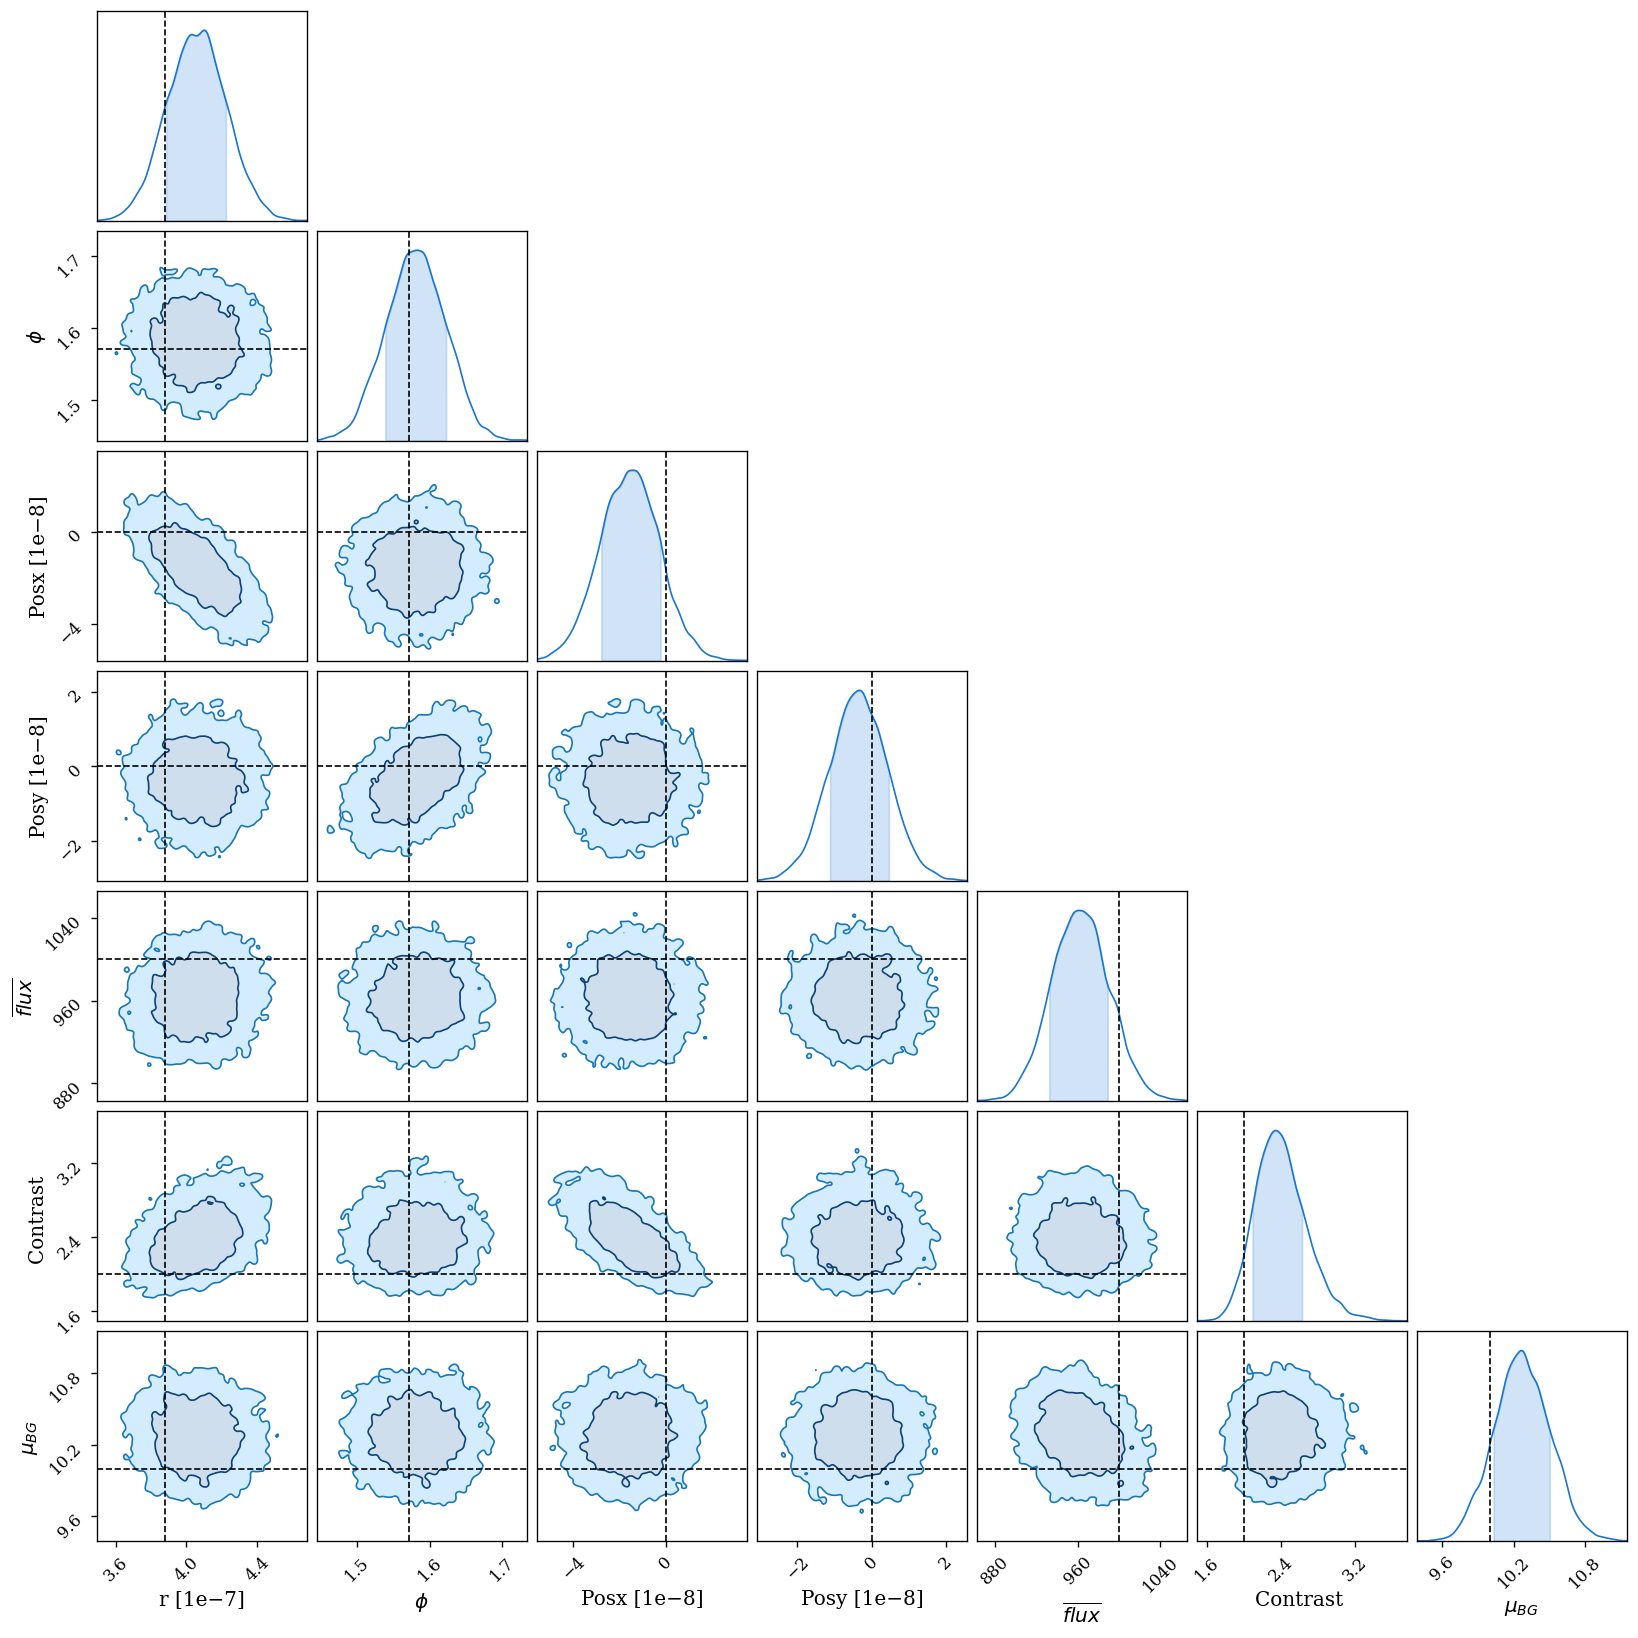

In [11]:
chain = cc.ChainConsumer()
chain.add_chain(chain_dict)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot(truth=truth_dict_in)
fig.set_size_inches((15,15));

Excellent! As we can see all of the praameters are well constrained!